# Sample 15arc-sec GEBCO_2020.nc + Bedmachine on OM4p125 grid

This notebook:
1. Apply edits to the topography.
2. Apply ice9 algorithm to fill lakes and inland seas. 

In [1]:
# Contributors:

# Stephen.Griffies@noaa.gov 
# Alistair.Adcroft@noaa.gov
# Robert.Hallberg@noaa.gov
# Niki.Zadeh@noaa.gov
# Raphael.Dussin@noaa.gov

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
import netCDF4
import xarray as xr
import cmocean
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

In [3]:
sns.set_style('white')
sns.set_context('paper', font_scale=2)
sns.set_palette('hls', 6)
sns.set_style('ticks')

In [4]:
human = False

## Functions

In [5]:
def ice9it(i,j,depth):
  # Iterative implementation of "ice 9"
  wetMask = 0*depth
  (nj,ni) = wetMask.shape
  stack = set()
  stack.add( (j,i) )
  while stack:
    (j,i) = stack.pop()
    if wetMask[j,i] or depth[j,i] >= 0: continue
    wetMask[j,i] = 1
    if i>0: stack.add( (j,i-1) )
    else: stack.add( (j,ni-1) )
    if i<ni-1: stack.add( (j,i+1) )
    else: stack.add( (0,j) )
    if j>0: stack.add( (j-1,i) )
    if j<nj-1: stack.add( (j+1,i) )
    else: stack.add( (j,ni-1-i) )
  return wetMask

In [6]:
def get_indices(lon_grid,lat_grid,x,y):
    """This function returns the j,i indices for the grid point closest 
    to the input lon(i,j),lat(i,j) coordinates."""
    """It returns the j,i indices."""
    
    cost=np.fabs((lon_grid-x)**2 + (lat_grid-y)**2)
    costm=np.where(cost==cost.min())

    j0=costm[0][0]
    i0=costm[1][0]
    
    print("from get_indices, wanted: ",x,y)
    print("from get_indices, got:    ",lon_grid[j0,i0] , lat_grid[j0,i0])
    print(j0,i0)
    return j0,i0


def get_indices_gebco(lon_grid,lat_grid,x,y):
    """This function returns the j,i indices for the grid point closest 
    to the input lon(i),lat(j) coordinates."""
    """It returns the j,i indices."""

    lons=np.fabs(np.squeeze(lon_grid)-x)
    lonm=np.where(lons==lons.min())
    lats=np.fabs(np.squeeze(lat_grid)-y)
    latm=np.where(lats==lats.min())  
    
    j0=latm[0][0]
    i0=lonm[0][0]

    #print("from get_indices_gebco, wanted: ",x,y)
    #print("from get_indices_gebco, got:    ",lon_grid[i0], lat_grid[j0])
    #print(j0,i0)
    return j0,i0

In [7]:
def map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgridG, ygridG, xgridM, ygridM, 
                           fieldG, fieldMa, fieldMb, fieldMc,
                           vmin, vmax, cmap, rname,
                           iskip, jskip, ioff, joff):
    """This function maps a region centered on (center_lon,center_lat) over (width_lon,width_lat)."""
    
    # GEBCO indices
    jsouthG,iwestG=get_indices_gebco(xgridG, ygridG, (center_lon-width_lon/2),(center_lat-width_lat/2))
    jnorthG,ieastG=get_indices_gebco(xgridG, ygridG, (center_lon+width_lon/2),(center_lat+width_lat/2))
    print('(jsouthG,iwestG) = ',jsouthG,',',iwestG) 
    print('(jnorthG,ieastG) = ',jnorthG,',',ieastG) 
 
    # MOM6 indices 
    jsouthM,iwestM=get_indices(xgridM, ygridM, (center_lon-width_lon/2),(center_lat-width_lat/2))
    jnorthM,ieastM=get_indices(xgridM, ygridM, (center_lon+width_lon/2),(center_lat+width_lat/2))
    print('(jsouthM,iwestM) = ',jsouthM,',',iwestM) 
    print('(jnorthM,ieastM) = ',jnorthM,',',ieastM) 

   
    xlimM=(xgridM[jsouthM:jnorthM,iwestM:ieastM].min(),xgridM[jsouthM:jnorthM,iwestM:ieastM].max())
    ylimM=(ygridM[jsouthM:jnorthM,iwestM:ieastM].min(),ygridM[jsouthM:jnorthM,iwestM:ieastM].max())

    xlimG = (xgridG[iwestG:ieastG].min(),xgridG[iwestG:ieastG].max())
    ylimG = (ygridG[jsouthG:jnorthG].min(),ygridG[jsouthG:jnorthG].max())

    # define the smallest common region to better view/compare the two datasets 
    xlim = (np.array([xlimM[0],xlimG[0]]).max(), np.array([xlimM[1],xlimG[1]]).min())
    ylim = (np.array([ylimM[0],ylimG[0]]).max(), np.array([ylimM[1],ylimG[1]]).min())
     
    xtickslim = (iwestM+ioff,ieastM-ioff)    
    ytickslim = (jsouthM+joff,jnorthM-joff)    
    # print('xtickslim = ',xtickslim) 
        
        
    plt.figure(figsize=(14,10)) 

    
    # GEBCO
    plt.subplot(2,2,1)
    fieldGmask = fieldG[jsouthG:jnorthG,iwestG:ieastG]
    fieldGmask = np.ma.array(fieldGmask, mask=(fieldGmask>=0.0))
    plt.pcolormesh(xgridG[iwestG:ieastG], 
                   ygridG[jsouthG:jnorthG], 
                   fieldGmask,
                   cmap=cmap,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.title('GEBCO-'+rname, fontsize=10)
    plt.xlabel("longitude",fontsize=15)
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 
    
    plt.contour(xgridG[iwestG:ieastG], 
                ygridG[jsouthG:jnorthG], 
                fieldG[jsouthG:jnorthG,iwestG:ieastG],
                levels=[-500,0],linestyles='solid',colors='green')  
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    
    
    # MOM6
    # The offset in indices for field is due to pcolormesh conventions
    plt.subplot(2,2,2)
    plt.pcolormesh(xgridM[jsouthM:jnorthM,iwestM:ieastM], 
                   ygridM[jsouthM:jnorthM,iwestM:ieastM], 
                   fieldMa[jsouthM:jnorthM-1,iwestM:ieastM-1],
                   cmap=cmap,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 
    plt.xlim(xlim)
    plt.ylim(ylim)
     
    # contour GEBCO over MOM    
    plt.contour(xgridG[iwestG:ieastG], 
                ygridG[jsouthG:jnorthG], 
                fieldG[jsouthG:jnorthG,iwestG:ieastG],
                levels=[-500,0],linestyles='solid',colors='green')  
    
    plt.title('GEBCO(cont)+MOM6-'+rname, fontsize=10)
    plt.xlabel("longitude",fontsize=15)
    plt.xlim(xlim)
    plt.ylim(ylim)
      
        
        
    # MOM6 topog as indices 
    plt.subplot(2,2,3)
    
    xindices = np.arange(iwestM,ieastM)-0.5
    yindices = np.arange(jsouthM,jnorthM)-0.5
    xint     = np.arange(iwestM,ieastM,iskip)
    yint     = np.arange(jsouthM,jnorthM,jskip)

    plt.pcolormesh(xindices, yindices,
                   fieldMb[jsouthM:jnorthM-1,iwestM:ieastM-1],
                   cmap=cmap,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.title('Indices MOM6-'+rname, fontsize=10)
    plt.xlabel("i-index",fontsize=15)
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 
    plt.yticks(yint)
    plt.xticks(xint)
    plt.xlim(xtickslim)
    plt.ylim(ytickslim)
   

    # MOM6
    # The offset in indices for field is due to pcolormesh conventions
    plt.subplot(2,2,4)
    plt.pcolormesh(xgridM[jsouthM:jnorthM,iwestM:ieastM], 
                   ygridM[jsouthM:jnorthM,iwestM:ieastM], 
                   fieldMc[jsouthM:jnorthM-1,iwestM:ieastM-1],
                   cmap=cmap,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 
    plt.xlim(xlim)
    plt.ylim(ylim)
     
    # contour GEBCO over MOM    
    plt.contour(xgridG[iwestG:ieastG], 
                ygridG[jsouthG:jnorthG], 
                fieldG[jsouthG:jnorthG,iwestG:ieastG],
                levels=[-500,0],linestyles='solid',colors='green')  
    
    plt.title('GEBCO(cont)+edited MOM6-'+rname, fontsize=10)
    plt.xlabel("longitude",fontsize=15)
    plt.xlim(xlim)
    plt.ylim(ylim)    


    plt.tight_layout()
    plt.show()
    
    return

## Open datasets

In [8]:
# GEBCO-2020 + Bedmachine combined topography 

fname_gebco  = "/work/Raphael.Dussin/BedMachine_Ant1/merged_BedMachineAntarctic_GEBCO2020.nc"
topog_gebco = netCDF4.Dataset(fname_gebco)

xgebco       = topog_gebco.variables['lon']
ygebco       = topog_gebco.variables['lat']
height_gebco = topog_gebco.variables['elevation']

print('----------------------------------------------------------------------------')
print('GEBCO-2020 dataset = ',fname_gebco)
print('xgebco.shape =', xgebco.shape)
print('ygebco.shape =', ygebco.shape)
print('height_gebco.shape =', height_gebco.shape)
print('----------------------------------------------------------------------------')

----------------------------------------------------------------------------
GEBCO-2020 dataset =  /work/Raphael.Dussin/BedMachine_Ant1/merged_BedMachineAntarctic_GEBCO2020.nc
xgebco.shape = (86400,)
ygebco.shape = (43200,)
height_gebco.shape = (43200, 86400)
----------------------------------------------------------------------------


In [9]:
# 1/8th degree MOM6 topography (has no application of ice9)

fname_model = "/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing.2.BedMachineTopo_Raph/topog_merged.nc"
topog_model = netCDF4.Dataset(fname_model)

fname_grid_model = "/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing.2/ocean_hgrid.nc"
grid_model       = netCDF4.Dataset(fname_grid_model)

print('----------------------------------------------------------------------------')
print(fname_grid_model)
print(grid_model)
print('----------------------------------------------------------------------------')
print(fname_model)
print(topog_model)
print('----------------------------------------------------------------------------')

# vorticity (q) points (best for pcolormesh to have edges of fields)
xmodel_q = grid_model.variables['x'][:][::2,::2]
ymodel_q = grid_model.variables['y'][:][::2,::2]

# thickness points
xmodel_h = grid_model.variables['x'][:][1::2,1::2]
ymodel_h = grid_model.variables['y'][:][1::2,1::2]

# define height = -depth corresponding to gebco
depth_model    = topog_model.variables['depth']
depth_model    = np.ma.masked_less(depth_model, 0.0, copy=True)

# define height_model to be edited and fixed (unedited) height_model0
height_model   = topog_model.variables['height']
height_model   = np.ma.masked_greater(height_model, 0.0, copy=True)
height_model0  = topog_model.variables['height']
height_model0  = np.ma.masked_greater(height_model0, 0.0, copy=True)

wet_model      = np.zeros(height_model.shape)
wet_model      = np.where(height_model<0.,1.0,0.0)

# sanity check that depth = -height in fact holds (it does)
diff_model     = height_model + depth_model 

# ymodel is in degrees. np.sin() wants radians. 
# ymodel is latitude even when north of bipolar fold.
# -1.0 to account for height = -depth
Omega    = 7.2921/1e5
coriolis = 2.0 * Omega * np.sin(ymodel_h*np.pi/180.0) * wet_model
foverh   = -1.0*coriolis/height_model

# for maps near lon=60=-300
# *8 since 1/8th degree 
shift = 60*8
# recall that x += 1 is short for x = x + 1, same for -=
height_model0_roll = np.roll(height_model0,shift,axis=1)
ymodel_q_roll      = np.roll(ymodel_q,shift,axis=1)
xmodel_q_roll      = np.roll(xmodel_q,shift,axis=1)
xmodel_q_roll[:,:shift] -= 360
xmodel_q_roll += 360.

#print('depth_model.shape = ',depth_model.shape, 'coriolis.shape = ',
#      coriolis.shape, 'foverh shape = ',foverh.shape )

----------------------------------------------------------------------------
/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing.2/ocean_hgrid.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    history: This grid file was generated via command pytools/grid_generation/ocean_grid_generator.py --write_subgrid_files -f ocean_hgrid.nc -r 8 --rdp 0.2 --south_cutoff_row 5 --match_dy --even_j on 2020-08-13 on platform an004
    description: This is an orthogonal coordinate grid for the Earth with a nominal resoution of 0.125 degrees along the equator. It consists of a Mercator grid spanning -66.8840965847 to 64.0316059408 degrees, flanked by a bipolar northern cap and a regular lat-lon grid spanning -66.8840965847 to -78.0 degrees. It is capped by a displaced pole grid south of -78.0 degrees. The first 5 rows at south are deleted.
    source: pytools/grid_generation/ocean_grid_generator.py had git hash 136ffe549c

<ipython-input-9-695a8f6eacf0>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(grid_model)
<ipython-input-9-695a8f6eacf0>:14: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(topog_model)


In [10]:
# sanity checks on the lon/lat arrays:

topolon = topog_model.variables['x'][:]
topolat = topog_model.variables['y'][:]

print(np.allclose(topolon, xmodel_h))
print(np.allclose(topolat, ymodel_h))

print((np.equal(topolon, xmodel_h)).all())
print((np.equal(topolat, ymodel_h)).all())

False
False
False
False


In [11]:
print((topolon - xmodel_h).min())
print((topolon - xmodel_h).max())

print((topolat - ymodel_h).min())
print((topolat - ymodel_h).max())

-29.893018670512106
11.543323180388114
-0.06249998760508915
0.027326597066249292


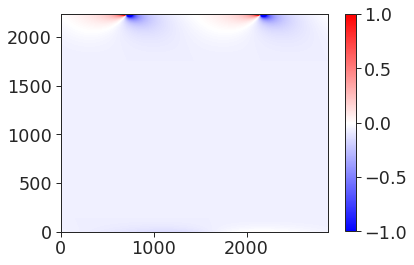

In [12]:
plt.pcolormesh(topolon - xmodel_h, vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()

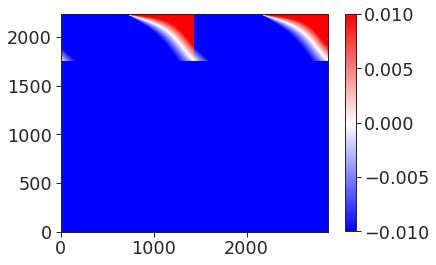

In [13]:
plt.pcolormesh(topolat - ymodel_h, vmin=-0.01, vmax=0.01, cmap='bwr')
plt.colorbar()

In [14]:
#MOM topog height before any edits 

vmax=0.0
vmin=-6500.0
field = height_model
x = xmodel_q
y = ymodel_q

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th before edits', fontsize=20)
    #cbar.ax.tick_params(labelsize=8)
    plt.show()

### ---------------------------------------------------------------------- 
### Mediterranean and Black Seas 
### ---------------------------------------------------------------------- 

In [15]:
#Broad view of Med and Black Sea before edits 

vmax=0.0
vmin=-5000.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-15,45)
ylim = (28,48)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Med and Black Seas', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
    plt.show()

In [16]:
# Close look at Strait of Gibraltar (no edits)
#
# Ensure Camarinal sill exists at narrowest point of Gibraltar.
# Note that Wikipedia says it is roughly 300m deep at 35deg 56min N and 5deg 45min W.
# But GEBCO has it deeper.  Will keep objective mapping of GEBCO.
#
# For the file MOM6-examples/ice_ocean_SIS2/OM4_0125/INPUT/MOM_channels_global_0125
# to have a 12km wide opening at Gibraltar 
# U_width,  -5.7,  -5.4, 35.8, 36.2,  12000.0  ! Gibraltar


fieldA = height_model0
#center_lon=-5.50 ; center_lat=36. ; width_lon=1.5 ; width_lat=.60
center_lon=-5.50 ; center_lat=36. ; width_lon=1.5 ; width_lat=6.0

vmin=-600.0 ; vmax=0.0;
if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Gibraltar',
                           iskip=2, jskip=2, ioff=2, joff=0)


In [17]:
#Verify that the Kerch Strait is open without any edits (connects Sea of Azov to Black Sea)

fieldA = height_model0
center_lon=37.0 ; center_lat=45. ; width_lon=3.0 ; width_lat=3.0
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat,
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Kerch Strait',
                           iskip=2, jskip=2, ioff=2, joff=0)

In [18]:
#Edit to open the Bosporus region at the southern exit of the Black Sea

# For the file MOM6-examples/ice_ocean_SIS2/OM4_0125/INPUT/MOM_channels_global_0125
# V_width,  28.8,  29.4, 41.1, 41.2,   1250.0  ! Bosporus - should be 1km wide.


fieldA = height_model0
center_lon=29.10 ; center_lat=41.25 ; width_lon=1.0 ; width_lat=1.0
vmin=-100.0 ; vmax=0.0; 

# Bosphorus 
height_model[1456,2632] = -60.0
height_model[1455,2632] = -60.0
height_model[1454,2632] = -60.0
height_model[1453,2632] = -60.0

# connect a piece of the Sea of Marmara to remainder of that sea 
height_model[1447,2630] = -60.0

# If set any point to zero then need to mask it.
#fieldMb = np.ma.array(fieldMb,mask=fieldMb>=0.0)

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Bosporus',
                           iskip=2, jskip=1, ioff=2, joff=0)

In [19]:
#Edits needed to open the Dardenelles connecting the Sea of Marmara to the Aegean Sea 

# For the file MOM6-examples/ice_ocean_SIS2/OM4_0125/INPUT/MOM_channels_global_0125
# U_width,  26.4, 26.7, 40.3, 40.5,   5000.0  ! Dardanelles

fieldA = height_model0
center_lon=26.80 ; center_lat=40.50 ; width_lon=2.0 ; width_lat=1.0
vmin=-100.0 ; vmax=0.0; 

# Dardenelles 
height_model[1447,2614] = -70.0
height_model[1448,2614] = -70.0
height_model[1447,2613] = -70.0
height_model[1446,2613] = -70.0
height_model[1446,2612] = -70.0
height_model[1445,2612] = -70.0
height_model[1445,2611] = -70.0
height_model[1444,2611] = -70.0
height_model[1444,2610] = -70.0

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Dardenelles',
                           iskip=1, jskip=1, ioff=2, joff=0)

In [20]:
#Edits needed to open the northern part of Peloponnesus peninsula of Greece 

fieldA = height_model0
center_lon=22.0 ; center_lat=38. ; width_lon=2.0 ; width_lat=2.0
vmin=-100.0 ; vmax=0.0; 

height_model[1425,2574] = -70.0
height_model[1425,2575] = -70.0

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Peloponnesus',
                           iskip=2, jskip=2, ioff=2, joff=0)

In [21]:
# Broad view of Med and Black Sea after editing 
#
# Warning: the dpi on a typical screen might be insufficient 
# to resolve all the land/sea connections. The Peloponnesus peninsula
# is a good case-in-point where some screen resolutions might show this peninsula  
# disconnected to the rest of Greece, whereas it is in fact connected (as we see in the 
# above cell).  

vmax=0.0
vmin=-5000.0
x = xmodel_q
y = ymodel_q

xlim = (-10,45)
ylim = (29,48)

xlim = (0,45)
ylim = (35,48)

if human:
    plt.figure(figsize=(20,12))

    plt.subplot(2,1,1)
    field = height_model0
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    #plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Med and Black Seas before editing', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)   

    plt.subplot(2,1,2)
    field = height_model
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Med and Black Seas after editing', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)   

   
    plt.show()

### ---------------------------------------------------------------------- 
### Red Sea
### ---------------------------------------------------------------------- 

In [22]:
#View of northern Red Sea (no edits) 

fieldA = height_model0
center_lon=35.0 ; center_lat=29. ; width_lon=7.0 ; width_lat=7.0
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Red Sea',
                           iskip=2, jskip=2, ioff=2, joff=0)

In [23]:
#View of southern Red Sea and Gulf of Aden (no edits)

fieldA = height_model0
center_lon=43.50 ; center_lat=13. ; width_lon=2.0 ; width_lat=2.0
vmin=-300.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Red Sea and Gulf of Aden',
                           iskip=10, jskip=5, ioff=2, joff=0)

### ---------------------------------------------------------------------- 
### Persian Gulf 
### ---------------------------------------------------------------------- 

In [24]:
# View of the Persian Gulf (no edits)

# for periodicity across x=60=-300 in model space. 
# *8 since 1/8th degree 
shift = 60*8
# recall that x += 1 is short for x = x + 1, same for -=
height_model_roll  = np.roll(height_model,shift,axis=1)

fieldA = height_model_roll
center_lon=55.0 ; center_lat=26. ; width_lon=15.0 ; width_lat=10.0
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Persian Gulf',
                           iskip=10, jskip=5, ioff=2, joff=0)

In [25]:
# Edits to fill some spots around Qatar to avoid small embayments that can 
# have excessive evaporation and thus get huge (> 60ppt) salinity.  
# Do not worry about land-locked points that will later be taken care of by ICE9.

fieldA = height_model0
center_lon=51.0 ; center_lat=25. ; width_lon=2.0 ; width_lat=3.0
vmin=-100.0 ; vmax=0.0; 

height_model[1297,2811] = 0.0
height_model[1295,2811] = 0.0
height_model[1294,2811] = 0.0

height_model[1298,2806] = 0.0
height_model[1299,2806] = 0.0

height_model[1305,2807] = 0.0


# If set any point to zero then need to mask it.
height_model = np.ma.array(height_model,mask=height_model>=0.0)

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Qatar',
                           iskip=2, jskip=2, ioff=2, joff=0)

### -----------------------------------------------------------------------------
### Indian Ocean
### -----------------------------------------------------------------------------

In [26]:
# Broad view of Indian Ocean (no edits)
#
# for periodicity across x=60=-300 in model space. 
# *8 since 1/8th degree 
shift = 60*8
# recall that x += 1 is short for x = x + 1, same for -=
height_model_roll  = np.roll(height_model,shift,axis=1)
field = height_model_roll

vmax=0.0
vmin=-5000.0
x = xmodel_q_roll
y = ymodel_q_roll

xlim = (0,130)
ylim = (-50,30)

if human:
    plt.figure(figsize=(20,12))

    #plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
    #               vmin=vmin, vmax=vmax)  

    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25,vmin=vmin, vmax=vmax)  

    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    #plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Indian Ocean', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)   
   
    plt.show()

### ---------------------------------------------------------------------- 
### Indonesian Islands
### ---------------------------------------------------------------------- 

In [27]:
#Broad view of Indonesian Seas before edits 

vmax=0.0
vmin=-0.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-270,-210)
ylim = (-20,20)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Indonesian Seas before edits', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

In [28]:
# Sunda Strait between Sumatra and Java 
# Edit to excavate one point on Sumatra to open the strait a bit more 

shift = 60*8
# recall that x += 1 is short for x = x + 1, same for -=
height_model_roll  = np.roll(height_model,shift,axis=1)

height_model_roll[1046,845] = -30.0

# now back out the roll in modifying height_model
shift = -60*8
height_model = np.roll(height_model_roll,shift,axis=1)


fieldA = height_model0_roll
center_lon=106 ; center_lat=-6.0 ; width_lon=2.0 ; width_lat=2.0
vmin=-60.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Java',
                           iskip=4, jskip=1, ioff=2, joff=0)

In [29]:
# Edits to separate Java from Bali

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)
height_model_roll[1027,915] = -30.0
height_model_roll[1028,915] = -30.0

# now back out the roll in modifying height_model
shift = -60*8
height_model  = np.roll(height_model_roll,shift,axis=1)

fieldA = height_model0_roll
center_lon=115 ; center_lat=-8.2 ; width_lon=2.0 ; width_lat=1.6
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax, 
                           cmap=cmocean.cm.deep, rname='Java-Bali',
                           iskip=2, jskip=1, ioff=2, joff=0)

In [30]:
#Sanity check that the above roll-trick worked on height_model
#to separate Java from Bali.

vmax=0.0
vmin=-100.0
field = height_model
x = xmodel_q
y = ymodel_q
xlim = (-246,-244)
ylim = (-9,-7)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 Java-Bali', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

In [31]:
# Edit to separate Lombok from Sumbawa and open up a bit of Sumbawa 

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)

# separate Lombok from Sumbawa
height_model_roll[1024,934] = -50.0

# open up a bit of Sumbawa
height_model_roll[1026,940] = -50.0


# now back out the roll and place into height_model (need to check this!)
shift = -60*8
height_model  = np.roll(height_model_roll,shift,axis=1)


fieldA = height_model0_roll
center_lon=117.5 ; center_lat=-8.5 ; width_lon=3.0 ; width_lat=1.5
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Lombok-Sumbawa',
                           iskip=2, jskip=1, ioff=2, joff=0)

In [32]:
#Verify that that above roll-trick worked on height_model in 
# separating Lombok from Sumbawa and open up a bit of Sumbawa 

vmax=0.0
vmin=-100.0
field = height_model
x = xmodel_q
y = ymodel_q
xlim = (-244,-241)
ylim = (-9,-8)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 Lombok and Sumbawa', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

In [33]:
# View of further east between Sumbawa and Flores islands (no edits)

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)


# now back out the roll and place into height_model (need to check this!)
#shift = -60*8
#height_model  = np.roll(height_model_roll,shift,axis=1)


fieldA = height_model0_roll
center_lon=120. ; center_lat=-8.5 ; width_lon=4.0 ; width_lat=1.5
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Sumbawa-Flores',
                           iskip=2, jskip=1, ioff=2, joff=0)

In [34]:
# Edits to fill in a spot along Flores island and deepen one spot

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)
height_model_roll[1023,980] = 0.0
height_model_roll[1025,979] = -50.0

height_model_roll = np.ma.array(height_model_roll,mask=height_model_roll>=0.0)

# now back out the roll and place into height_model (need to check this!)
shift = -60*8
height_model  = np.roll(height_model_roll,shift,axis=1)


fieldA = height_model0_roll
center_lon=122. ; center_lat=-8.5 ; width_lon=4.0 ; width_lat=1.5
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Flores Island',
                           iskip=2, jskip=1, ioff=2, joff=0)

In [35]:
# View further east towards Timor (no edits)

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)

# now back out the roll and place into height_model (need to check this!)
#shift = -60*8
#height_model  = np.roll(height_model_roll,shift,axis=1)


fieldA = height_model0_roll
center_lon=125. ; center_lat=-8.5 ; width_lon=4.0 ; width_lat=1.5
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Timor region',
                           iskip=2, jskip=1, ioff=2, joff=0)

In [36]:
# View of Timor Sea (no edits)

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)

# now back out the roll and place into height_model (need to check this!)
#shift = -60*8
#height_model  = np.roll(height_model_roll,shift,axis=1)


fieldA = height_model0_roll
center_lon=126. ; center_lat=-9.50 ; width_lon=4.0 ; width_lat=4.5
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Timor Sea',
                           iskip=2, jskip=2, ioff=2, joff=0)

In [37]:
# Edits to disconnect Buton from Celebes. 
# Allow Muna and Buton to be merged into a single island 

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)
height_model_roll[1057,983] = -20.0
height_model_roll[1058,983] = -20.0

# now back out the roll and place into height_model (need to check this!)
shift = -60*8
height_model  = np.roll(height_model_roll,shift,axis=1)

fieldA = height_model0_roll
center_lon=123. ; center_lat=-4.5 ; width_lon=3.0 ; width_lat=2.5
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Celebes-Buton',
                           iskip=2, jskip=1, ioff=2, joff=0)

In [38]:
#Broad view of Indonesian Seas after the edits 

vmax=0.0
vmin=-0.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-270,-210)
ylim = (-20,20)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Indonesian Seas after edits', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

### ---------------------------------------------------------------------- 
### Phillipines
### ---------------------------------------------------------------------- 

In [39]:
# View of South Phillipine Islands (no edits)

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)

# now back out the roll and place into height_model (need to check this!)
#shift = -60*8
#height_model  = np.roll(height_model_roll,shift,axis=1)

fieldA = height_model0_roll
center_lon=123. ; center_lat=8 ; width_lon=8.0 ; width_lat=6.0
vmin=-10.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='South Phillipines',
                           iskip=4, jskip=4, ioff=2, joff=0)

In [40]:
# View of North Phillipine Islands (no edits)

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)

# now back out the roll and place into height_model (need to check this!)
#shift = -60*8
#height_model  = np.roll(height_model_roll,shift,axis=1)

fieldA = height_model0_roll
center_lon=123. ; center_lat=12 ; width_lon=8.0 ; width_lat=6.0
vmin=-10.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='North Phillipines',
                           iskip=4, jskip=4, ioff=2, joff=0)

### ---------------------------------------------------------------------- 
### SouthEast Asia
### ---------------------------------------------------------------------- 

In [41]:
#Broad view of SouthEast Asia (no edits)

vmax=0.0
vmin=-0.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-245,-200)
ylim = (25,45)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th SouthEast Asia', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

In [42]:
# Kyushu from Honshu Japanese islands (no edits; keep them linked) 

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)

# now back out the roll and place into height_model (need to check this!)
#shift = -60*8
#height_model  = np.roll(height_model_roll,shift,axis=1)

fieldA = height_model0_roll
center_lon=131. ; center_lat=33.5 ; width_lon=3.0 ; width_lat=2.0
vmin=-10.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Kyushu and Honshu (Japan)',
                           iskip=2, jskip=2, ioff=2, joff=0)

In [43]:
# Check Honshu and Hokkaido Japanese islands (no edits)

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)

# now back out the roll and place into height_model (need to check this!)
#shift = -60*8
#height_model  = np.roll(height_model_roll,shift,axis=1)

fieldA = height_model0_roll
center_lon=141. ; center_lat=41.5 ; width_lon=4.0 ; width_lat=2.0
vmin=-300.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Honshu + Hokkaido (Japan)',
                           iskip=2, jskip=2, ioff=2, joff=0)

### ---------------------------------------------------------------------- 
### Northwest Pacific
### ---------------------------------------------------------------------- 

In [44]:
# Broad view of Northwest Pacific

vmax=0.0
vmin=-0.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-230,-180)
ylim = (35,70)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Northwest Pacific', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

In [45]:
# Edit to open the Tartar Strait between Sakhalin and Russia 

# For MOM6 channel table 
# V_width, 141.4, 141.7, 52.1,  52.2, 2500.0  ! Between Sakhalin and Russia

shift = 60*8
height_model_roll  = np.roll(height_model,shift,axis=1)
height_model_roll[1584,1132] = -15.0

# now back out the roll and place into height_model 
shift = -60*8
height_model = np.roll(height_model_roll,shift,axis=1)

fieldA = height_model0_roll
center_lon=141.5 ; center_lat=52.2 ; width_lon=2.0 ; width_lat=1.0
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q_roll, ymodel_q_roll, height_gebco,
                           fieldA, fieldA, height_model_roll, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Tartar Strait',
                           iskip=2, jskip=2, ioff=2, joff=0)

### ---------------------------------------------------------------------- 
### Northeast Pacific
### ---------------------------------------------------------------------- 

In [46]:
#Broad view of Northeast Pacific (no edits)

vmax=0.0
vmin=-0.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-180,-100)
ylim = (35,70)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Northeast Pacific', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

### ---------------------------------------------------------------------- 
### Gulf of Mexico and Caribbean Sea
### ---------------------------------------------------------------------- 

In [47]:
#Broad view of Gulf of Mexico and Caribbean Sea

vmax=0.0
vmin=-0.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-100,-40)
ylim = (0,35)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Gulf of Mexico and Caribbean Sea', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

### ---------------------------------------------------------------------- 
### South America
### ---------------------------------------------------------------------- 

In [48]:
# Edits to open Lake Maracaibo in Northern Venezuela 

fieldA = height_model0
center_lon=-71.5 ; center_lat=11 ; width_lon=2.0 ; width_lat=2.0
vmin=-50.0 ; vmax=0.0; 

height_model[1180,1827] = -10.0
height_model[1179,1827] = -10.0

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Lake Maracaibo',
                           iskip=2, jskip=2, ioff=2, joff=0)


In [49]:
# Edits to open some of the channels at the mouth of Amazon

fieldA = height_model0
center_lon=-50. ; center_lat=-.5 ; width_lon=5.0 ; width_lat=5.0
vmin=-50.0 ; vmax=0.0; 

height_model[1094,1995] = -10.0
height_model[1096,1996] = -10.0

height_model[1091,1995] = -10.0

height_model[1093,2002] = -10.0

height_model[1080,2008] = -10.0
height_model[1080,2009] = -10.0
height_model[1081,2010] = -10.0
height_model[1079,2005] = -10.0
height_model[1078,1994] = -10.0
height_model[1078,1999] = -10.0
height_model[1078,2000] = -10.0
height_model[1078,2001] = -10.0
height_model[1078,2002] = -10.0
height_model[1078,2003] = -10.0

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Amazon',
                           iskip=2, jskip=2, ioff=2, joff=0)

### ---------------------------------------------------------------------- 
### North Atlantic
### ---------------------------------------------------------------------- 

In [50]:
#Broad view of Nortwest Atlantic

vmax=0.0
vmin=-0.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-90,-30)
ylim = (20,90)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Northwest Atlantic', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

In [51]:
# Edit to add one point to connect Cape Cod 

fieldA = height_model0
center_lon=-70. ; center_lat=41.7 ; width_lon=2.0 ; width_lat=2.0
vmin=-100.0 ; vmax=0.0; 

height_model[1462,1839] = 0.0
height_model = np.ma.array(height_model,mask=height_model>=0.0)

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Cape Cod',
                           iskip=1, jskip=1, ioff=2, joff=0)

In [52]:
#View of New York's Long Island (no edits)

fieldA = height_model0
center_lon=-73. ; center_lat=41. ; width_lon=3.0 ; width_lat=2.0
vmin=-100.0 ; vmax=0.0; 

if human:
    map_region_model_gebco(center_lon, center_lat, width_lon, width_lat, 
                           xgebco, ygebco, xmodel_q, ymodel_q, height_gebco,
                           fieldA, fieldA, height_model, vmin=vmin, vmax=vmax,
                           cmap=cmocean.cm.deep, rname='Long Island',
                           iskip=2, jskip=2, ioff=2, joff=0)


In [53]:
#Norteast Atlantic (no edits)

vmax=0.0
vmin=-0.0
field = height_model0
x = xmodel_q
y = ymodel_q
xlim = (-10,20)
ylim = (20,70)

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th Northeast Atlantic', fontsize=20)
    plt.xlim(xlim)
    plt.ylim(ylim)    
   
    plt.show()

### ---------------------------------------------------------------------- 
### Apply ice9
### ---------------------------------------------------------------------- 

In [54]:
# Do ice9 to fill inland seas and lakes.  

# Warning: This step should be done after all other edits since 
# some edits might open up straits that we wish ice9 to know about.
# A case-in-point is the Black Sea. 

# make a 100 meters ice wall at southern edge
height_model_wall = height_model.copy()
height_model_wall[0,:] = 100.

# ice9 works on unmasked arrays. 
height_model_ice9 = np.ma.filled(height_model_wall, fill_value=0.0)

# Seed can be any wet ocean point.
jseed,iseed=get_indices(xmodel_q, ymodel_q, -150.0, 0.0)
ice9_mask = ice9it(iseed,jseed, height_model_ice9)

# Zero out inland seas and lakes.
height_model_ice9 = height_model_ice9 * ice9_mask

# Apply masking for nicer maps. 
height_model_ice9 = np.ma.masked_equal(height_model_ice9, 0.0, copy=True)

# Compute difference made by ice9 application. 
height_diff = height_model_ice9 - height_model
height_diff = np.ma.filled(height_diff, fill_value=0.0)


print(xmodel_q[jseed,iseed],ymodel_q[jseed,iseed], wet_model[jseed,iseed], 
      height_model[jseed,iseed], height_model_ice9[jseed,iseed])

from get_indices, wanted:  -150.0 0.0
from get_indices, got:     -150.0 -0.06249998760508915
1093 1200
-150.0 -0.06249998760508915 1.0 -4309.65625 -4309.65625


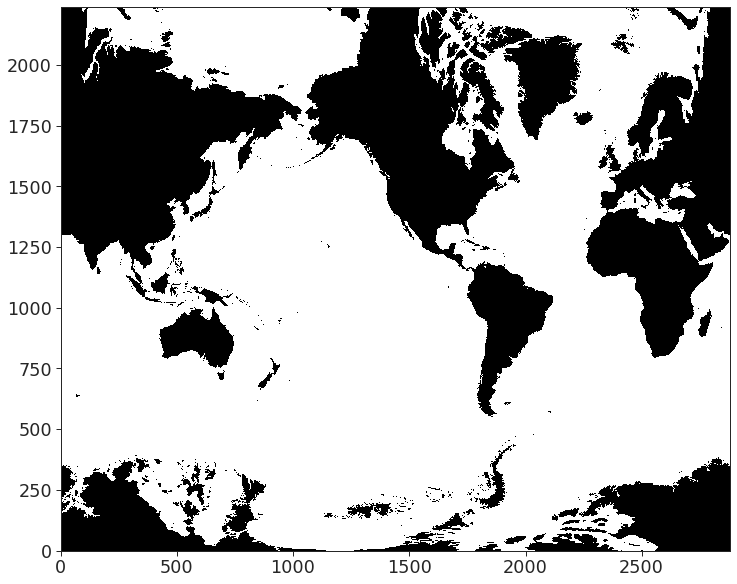

In [55]:
plt.figure(figsize=[12,10])
plt.pcolormesh(ice9_mask, cmap='binary_r')

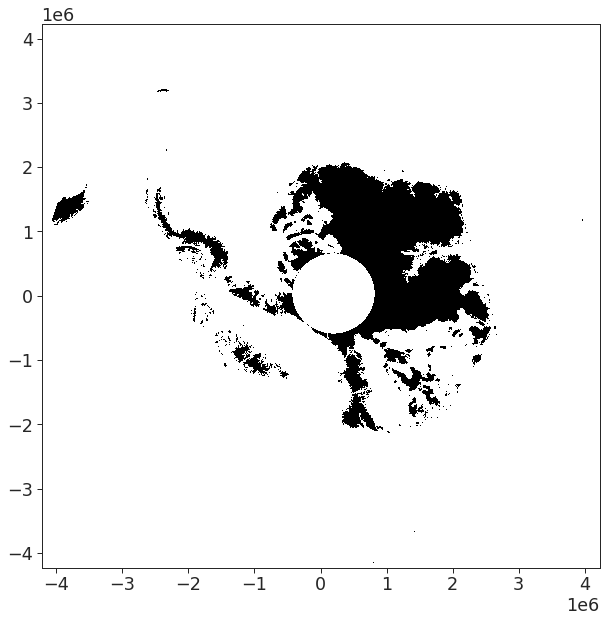

In [56]:
from pyproj import CRS, Transformer
# create the coordinate reference system
PROJSTRING="+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
crs = CRS.from_proj4(PROJSTRING)
# create the projection from lon/lat to x/y
proj = Transformer.from_crs(crs.geodetic_crs, crs)
# make x,y 2d arrays
#xx, yy = np.meshgrid(ds[x].values, ds[y].values)
# compute the lon/lat
xx,yy = proj.transform(xmodel_q[:600,:], ymodel_q[:600,:])

plt.figure(figsize=[10,10])
plt.pcolormesh(xx,yy,ice9_mask[:600,:], cmap='binary_r')

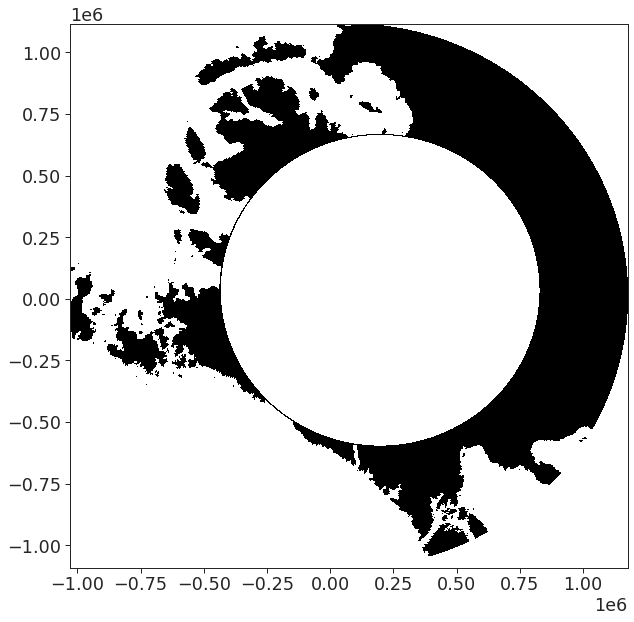

In [57]:
from pyproj import CRS, Transformer
# create the coordinate reference system
PROJSTRING="+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
crs = CRS.from_proj4(PROJSTRING)
# create the projection from lon/lat to x/y
proj = Transformer.from_crs(crs.geodetic_crs, crs)
# make x,y 2d arrays
#xx, yy = np.meshgrid(ds[x].values, ds[y].values)
# compute the lon/lat
xx,yy = proj.transform(xmodel_q[:100,:], ymodel_q[:100,:])

plt.figure(figsize=[10,10])
plt.pcolormesh(xx,yy,ice9_mask[:100,:], cmap='binary_r')

### ---------------------------------------------------------------------- 
### Produce final file
### ---------------------------------------------------------------------- 

In [58]:
# Steve's original code

# save to netCDF file. 
# MOM6 expects depth. 

#depth = -1.0*height_model_ice9
#depth = np.ma.filled(depth, fill_value=0.0)

#nx = np.max(depth[1,:].shape)
#ny = np.max(depth[:,1].shape)
#xlon = np.arange(nx)
#ylat = np.arange(ny)
#lon  = xr.DataArray(data=xlon, dims=('lon'))
#lat  = xr.DataArray(data=ylat, dims=('lat'))
#topog_darray = xr.DataArray(data=depth, dims=('lat', 'lon'))
#topog_darray = topog_darray.assign_coords({'lat': lat, 'lon': lon})

#topog_ds = xr.Dataset()
#topog_ds['depth'] = topog_darray
#topog_ds.to_netcdf('ocean_topog.nc', mode='w')




In [59]:
# save to netCDF file. 
# MOM6 expects depth. 

depth = -1.0*height_model_ice9

datadepth = depth.data
datadepth[depth.mask] = 0.

old_topo = xr.open_dataset(fname_model)
new_topo = old_topo.copy(deep=True)
new_topo['depth'] = xr.DataArray(datadepth, dims=old_topo['depth'].dims)
# make sure we have the right values for lon/lat arrays
new_topo['x'] = xr.DataArray(xmodel_h, dims=old_topo['x'].dims)
new_topo['y'] = xr.DataArray(xmodel_h, dims=old_topo['y'].dims)
new_topo['tile'] = xr.DataArray([1.], dims=('ntiles'))

# set up encoding and attributes
encoding = {'depth': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'height': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'h2': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'h_std': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'h_min': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'h_max': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'x': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'y': {'_FillValue': 1.0e+20, 'dtype': np.float64},
            'tile': {'_FillValue': 1.0e+20, 'dtype': np.float64},
           }


new_topo['x'].attrs = {'units': 'degrees_east'}
new_topo['y'].attrs = {'units': 'degrees_north'}
new_topo['depth'].attrs.update(dict(coordinates="x y"))
new_topo['height'].attrs.update(dict(coordinates="x y"))
new_topo['h2'].attrs.update(dict(coordinates="x y"))
new_topo['h_std'].attrs.update(dict(coordinates="x y"))
new_topo['h_min'].attrs.update(dict(coordinates="x y"))
new_topo['h_max'].attrs.update(dict(coordinates="x y"))

# update the history
new_topo.attrs['history'] += '; topograpy edits by Stephen Griffies'

new_topo.to_netcdf('ocean_topog.nc', encoding=encoding,
                   format='NETCDF3_64BIT', engine='netcdf4')

### ---------------------------------------------------------------------- 
### Post verification
### ---------------------------------------------------------------------- 

In [60]:
human = True

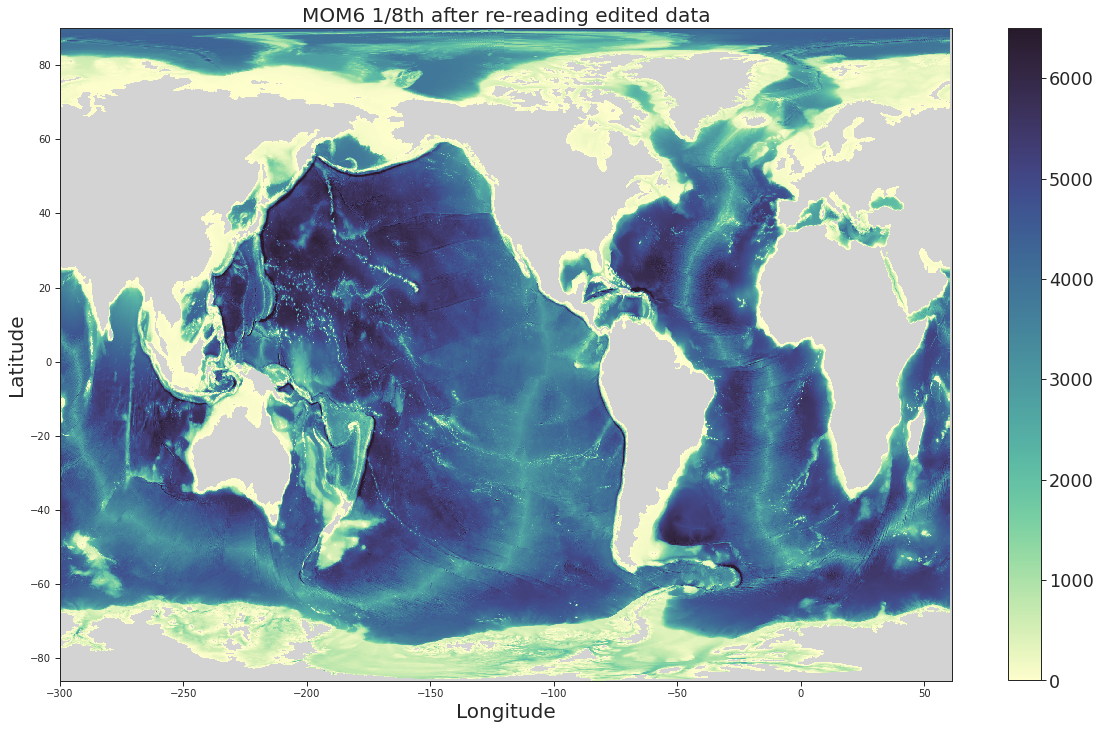

In [61]:
# check to be sure writing proper data 

fname  = "ocean_topog.nc"
test   = netCDF4.Dataset(fname)
depth_test = test.variables['depth']
depth_test = np.ma.masked_less_equal(depth_test, 0.0, copy=True)

vmin=0.0
vmax=6500.0
field = depth_test
x = xmodel_q
y = ymodel_q

if human:
    plt.figure(figsize=(20,12)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th after re-reading edited data', fontsize=20)
    #cbar.ax.tick_params(labelsize=8) 
   
    plt.show()

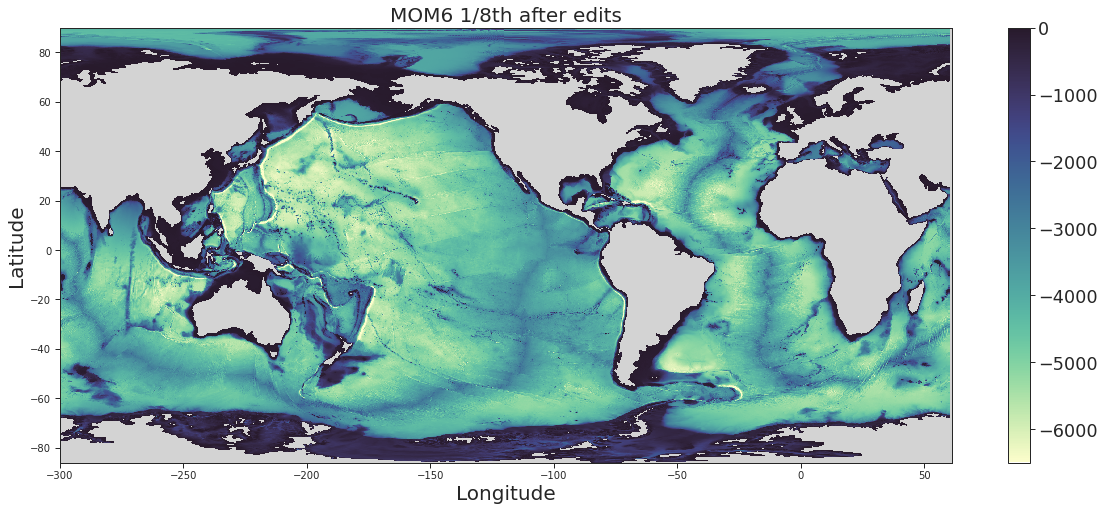

In [62]:
#MOM topog height 

vmax=0.0
vmin=-6500.0
field = height_model_ice9
x = xmodel_q
y = ymodel_q

if human:
    plt.figure(figsize=(20,8)) 
    plt.pcolormesh(x,y,field,cmap=cmocean.cm.deep,linewidths=0.25, 
                   vmin=vmin, vmax=vmax)  
    plt.gca().set_facecolor('lightgray')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    cbar = plt.colorbar()
    plt.title('MOM6 1/8th after edits', fontsize=20)
    #cbar.ax.tick_params(labelsize=8) 
   
    plt.show()